In [1]:
'''
Editor: @Hyunhomo
Source: https://github.com/mohyunho/abnormal_temperature_prediction

Load merged&labeled features and train machine learning model
'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from datetime import datetime
from sklearn.ensemble import GradientBoostingClassifier

## Load features from csv files
labeled_temp_feat = pd.read_csv('labeled_temp_feat.csv')
labeled_temp_feat['date'] = pd.to_datetime(labeled_temp_feat['date'], format="%Y-%m-%d %H:%M:%S")



## Function to derive current time with the format of pandas timestamp '%Y-%m-%d %H:%M:00' 
def current_time():
    ct = datetime.now()
    ct_minute = ct.strftime('%Y-%m-%d %H:00:00')
#     ct_ts = pd.to_datetime(ct_minute)
    ct_ts = pd.Timestamp(ct_minute, freq='t')
    return ct_ts

## Generate a fixed frequency DatetimeIndex
# Set current time(minute) as the threshold for training/test dataset split 
current_minute = current_time()

print ("labeled_temp_feat['date'][0]", labeled_temp_feat['date'][0] )

threshold_dates = [[labeled_temp_feat['date'][0],current_minute ],
                   [current_minute, labeled_temp_feat['date'].iloc[-1]]]

for last_train_date, first_test_date in threshold_dates:
    print ("last_train_date", last_train_date)
    print("first_test_date", first_test_date)


print ("current_minute", current_minute)
print ("Total number of instances", len(labeled_temp_feat['date']))
print ("The number of training instances", np.where(labeled_temp_feat['date']==current_minute)[0][0]+1)
print ("The number of test instances", len(labeled_temp_feat['date']) - (np.where(labeled_temp_feat['date']==current_minute)[0][0]+1) )

print ("labeled_temp_feat",  labeled_temp_feat)

# make test and training splits
test_results = []
models = []
last_train_date = current_minute
first_test_date  = current_minute
print ("last_train_date", last_train_date)
# split out training and test data
train_y = labeled_temp_feat.loc[labeled_temp_feat['date'] < last_train_date, 'label']
print ("train_y", train_y)
train_X = pd.get_dummies(labeled_temp_feat.loc[labeled_temp_feat['date']  < last_train_date].drop(['date',
                                                                                                    'label'], 1))

print ("train_X", train_X)
test_X = pd.get_dummies(labeled_temp_feat.loc[labeled_temp_feat['date'] > first_test_date].drop(['date',
                                                                                                'label'], 1))




labeled_temp_feat['date'][0] 2018-01-31 00:10:00
last_train_date 2018-01-31 00:10:00
first_test_date 2020-01-22 08:00:00
last_train_date 2020-01-22 08:00:00
first_test_date 2020-02-27 23:20:00
current_minute 2020-01-22 08:00:00
Total number of instances 109148
The number of training instances 103872
The number of test instances 5276
labeled_temp_feat                       date  max_temp_10_min  min_temp_10_min  \
0      2018-01-31 00:10:00        20.723264        18.585998   
1      2018-01-31 00:20:00        20.785159        18.713738   
2      2018-01-31 00:30:00        20.190654        18.773051   
3      2018-01-31 00:40:00        20.208956        18.939912   
4      2018-01-31 00:50:00        20.083399        19.404427   
...                    ...              ...              ...   
109143 2020-02-27 22:40:00        20.375105        19.023487   
109144 2020-02-27 22:50:00        20.613113        19.433738   
109145 2020-02-27 23:00:00        21.102557        19.399657   
109146 

model loaded
test_result                       date  max_temp_10_min  min_temp_10_min  \
103872 2020-01-22 08:10:00        20.795747        19.005282   
103873 2020-01-22 08:20:00        22.218074        20.373248   
103874 2020-01-22 08:30:00        22.254910        19.644115   
103875 2020-01-22 08:40:00        20.238050        19.345156   
103876 2020-01-22 08:50:00        20.861797        19.273746   
...                    ...              ...              ...   
109143 2020-02-27 22:40:00        20.375105        19.023487   
109144 2020-02-27 22:50:00        20.613113        19.433738   
109145 2020-02-27 23:00:00        21.102557        19.399657   
109146 2020-02-27 23:10:00        20.610408        19.077929   
109147 2020-02-27 23:20:00        21.083886        19.174108   

        mean_temp_10_min  std_temp_10_min  var_temp_10_min  \
103872         19.964864         0.595649         0.354798   
103873         21.253955         0.514321         0.264526   
103874         20.75

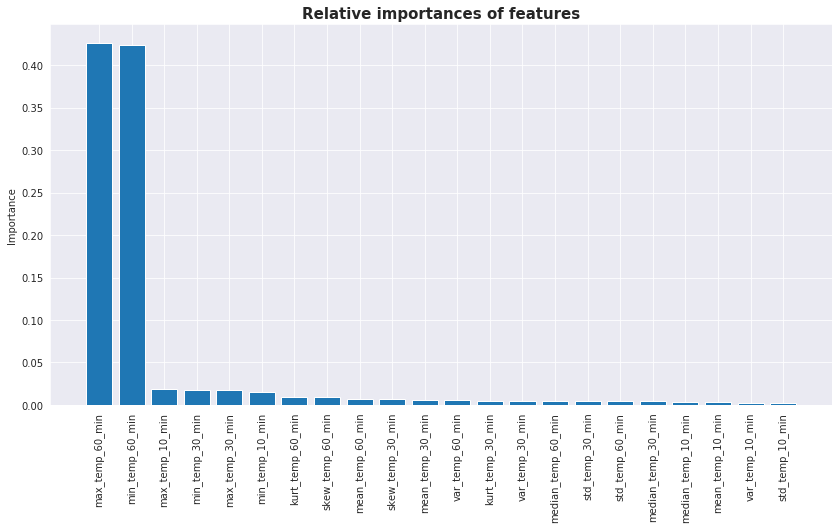

In [2]:
## Load trained model
filename = 'Temp_GB_PdM_model.sav'
my_model = pickle.load(open(filename, 'rb'))
print("model loaded")


## make prediction(test)
test_result = pd.DataFrame(labeled_temp_feat.loc[labeled_temp_feat['date'] > first_test_date])
test_result['predicted_state'] = my_model.predict(test_X)
print ("test_result", test_result)
test_results.append(test_result)
models.append(my_model)

##save prediction result to csv file
export_test_csv = test_results[0].to_csv('test_result_temp_GB.csv')
# test_results = pd.read_csv('test_result_GBC.csv')

sns.set_style("darkgrid")
plt.figure(figsize=(14, 7))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_), reverse=True, key=lambda x: x[1]))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')
plt.title("Relative importances of features", fontdict={'fontsize':15, 'fontweight':'bold'})
plt.savefig('barchart_importances.png', bbox_inches='tight')

In [3]:
### Evaluation

from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score


def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []

    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)

    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(['accuracy', 'precision', 'recall', 'F1'])

    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(['macro precision', 'macro recall', 'macro F1'])

    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis=1)
    cm_col_sums = cm.sum(axis=0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis=1)

    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0, 0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(['average accuracy',
                          'micro-averaged precision/recall/F1'])

    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist
    mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist
    mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(['majority class accuracy', 'majority class recall',
                          'majority class precision', 'majority class F1'])

    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(['expected accuracy', 'kappa'])

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(['random guess accuracy', 'random guess precision',
                          'random guess recall', 'random guess F1'])

    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist ** 2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(['random weighted guess accuracy',
                          'random weighted guess precision',
                          'random weighted guess recall',
                          'random weighted guess F1'])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels

    return output_df


evaluation_results = []
for i, test_result in enumerate(test_results):
    print('\nSplit %d:' % (i + 1))
    evaluation_result = Evaluate(actual=test_result['label'],
                                 predicted=test_result['predicted_state'],
                                 labels=['none', 'abnormal(cold)', 'abnormal(hot)'])
    evaluation_results.append(evaluation_result)
print (evaluation_results[0])  # show full results for first split only


Split 1:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[4778   24   29]
 [  27  146    1]
 [  54    1  216]]
                                        none  abnormal(cold)  abnormal(hot)
accuracy                            0.974223        0.974223       0.974223
precision                           0.983330        0.853801       0.878049
recall                              0.989029        0.839080       0.797048
F1                                  0.986171        0.846377       0.835590
macro precision                     0.905060        0.905060       0.905060
macro recall                        0.875053        0.875053       0.875053
macro F1                            0.889379        0.889379       0.889379
average accuracy                    0.982815        0.982815       0.982815
micro-averaged precision/recall/F1  0.974223        0.974223       0.974223
majority class accuracy             0.915656        0.000000       0.000000
majority 

<Figure size 864x432 with 0 Axes>

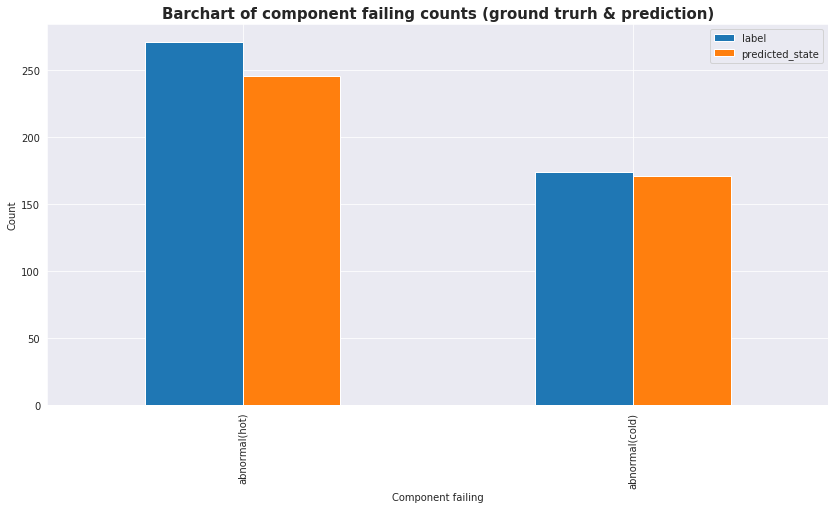

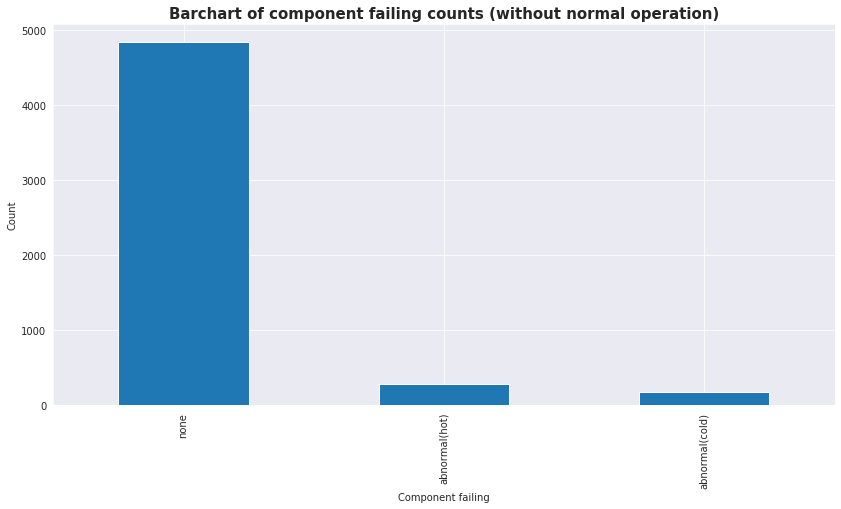

In [4]:

## Draw the barchart of component failing(ground trurh & prediction)
plt.figure(figsize=(12, 6))
counts_failures = test_result['label'].value_counts().drop('none')
counts_pd_failures = test_result['predicted_state'].value_counts().drop('none')
counts = pd.concat([counts_failures,counts_pd_failures],axis=1)
# print ("counts", counts )
sns.set_style("darkgrid")
ax = counts.plot(kind='bar', legend='true')
fig = plt.gcf()
fig.set_size_inches(14,7)
plt.xlabel('Component failing')
plt.ylabel('Count')
plt.title("Barchart of component failing counts (ground trurh & prediction)" , fontdict = {'fontsize':15, 'fontweight':'bold'})
plt.savefig('barchart_truth.png', bbox_inches='tight')


## Draw the barchart of component failing(ground trurh)
sns.set_style("darkgrid")
plt.figure(figsize=(14, 7))
test_result['label'].value_counts().plot(kind='bar')
plt.xlabel('Component failing')
plt.ylabel('Count')
plt.title("Barchart of component failing counts (without normal operation)" , fontdict = {'fontsize':15, 'fontweight':'bold'})
plt.savefig('barchart_truth(w none).png', bbox_inches='tight')


In [5]:

pd.set_option('display.max_rows', 1000)
print (test_result[['min_temp_10_min','max_temp_10_min','date','label','predicted_state']].to_string(index=False))


 min_temp_10_min  max_temp_10_min                date           label predicted_state
       19.005282        20.795747 2020-01-22 08:10:00            none            none
       20.373248        22.218074 2020-01-22 08:20:00            none            none
       19.644115        22.254910 2020-01-22 08:30:00            none            none
       19.345156        20.238050 2020-01-22 08:40:00            none            none
       19.273746        20.861797 2020-01-22 08:50:00            none            none
       18.409075        19.522591 2020-01-22 09:00:00            none            none
       18.896982        20.663158 2020-01-22 09:10:00            none            none
       18.319684        20.399364 2020-01-22 09:20:00            none            none
       18.175884        21.597070 2020-01-22 09:30:00            none            none
       19.387387        21.629648 2020-01-22 09:40:00            none            none
       19.650420        21.427431 2020-01-22 09:50:00 

my_model.classes_  ['abnormal(cold)' 'abnormal(hot)' 'none']
state abnormal(cold)

[0 0 0 ... 0 0 0]
unique [0 1]
counts [5102  174]
state abnormal(hot)

[0 0 0 ... 0 0 0]
unique [0 1]
counts [5005  271]
state none

[1 1 1 ... 1 1 1]
unique [0 1]
counts [ 445 4831]


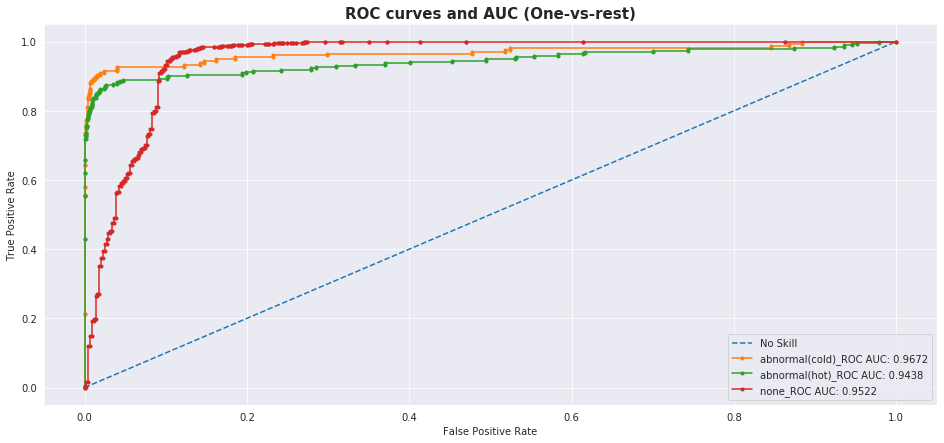

In [8]:
'''
Illustate the result with ROC curves and AUC score
ROC Curve: Plot of False Positive Rate (x) vs. True Positive Rate (y), (fpr, tpr)
TruePositiveRate = TruePositives / (TruePositives + False Negatives)
FalsePositiveRate = FalsePositives / (FalsePositives + TrueNegatives)
'''
# example of a roc curve for a predictive model
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score



# retrieve predict probability (for 5 multiclass)
proba_array = my_model.predict_proba(test_X)
# convert pandas dataseries of ground truth to numpy array
truth_array = test_result['label'].to_numpy()

# temporal array (same shape to ground truth array)
truth_array_temp =  np.zeros(len(truth_array) )
# blank python lisst to append each truth array
testy_bi = []

# classes_ attribute indicates output classes
print("my_model.classes_ ", my_model.classes_ )

# loop for converting categorical data into one-hot encoded binary 
for comp in my_model.classes_ :
    print ("state", comp)
    print ()
    truth_array_temp[truth_array!=comp]=np.int64(0)
    truth_array_temp[truth_array==comp]=np.int64(1)
    truth_array_temp = np.int64(truth_array_temp)
    print (truth_array_temp)
    unique, counts = np.unique(truth_array_temp, return_counts=True)
    print ("unique", unique)
    print("counts",counts)
    testy_bi.append(truth_array_temp)
    truth_array_temp =  np.zeros(len(truth_array) )


    
    
plt.figure(figsize=(16,7))
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# loop for each class (i.e., iteration for each type of failure)
for idx in range(len(my_model.classes_)):
    # retrieve just the probabilities for the positive class
    # calculate roc curve for model
    fpr, tpr, thres_roc = roc_curve(testy_bi[idx], proba_array[:,idx])
#     print ("thres_roc", thres_roc)
    # calculate ROC AUC
    roc_auc = roc_auc_score(testy_bi[idx], proba_array[:,idx])
    roc_auc = np.around(roc_auc, decimals=4)
    # plot model roc curve
    plt.plot(fpr, tpr, marker='.', label=my_model.classes_[idx] + '_ROC AUC: ' + str(roc_auc))
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
plt.title("ROC curves and AUC (One-vs-rest)" , fontdict = {'fontsize':15, 'fontweight':'bold'})
plt.savefig('ROC_AUC.png', bbox_inches='tight')


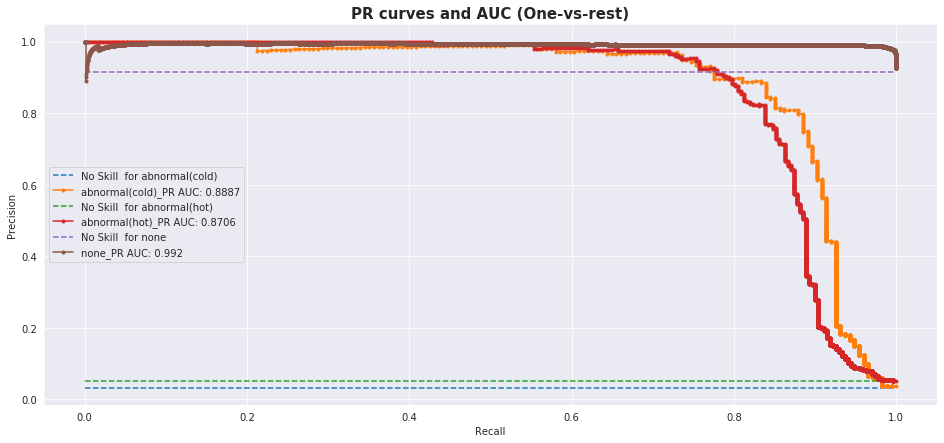

In [9]:
'''
Precision-Recall Curves and AUC
Precision-Recall(PR) Curve: Plot of Recall (x) vs Precision (y).
Precision = TruePositives / (TruePositives + FalsePositives)
Recall = TruePositives / (TruePositives + FalseNegatives)

'''
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc



plt.figure(figsize=(16,7))

# loop for each class (i.e., iteration for each type of failure)
for idx in range(len(my_model.classes_)):
    test_y_bi_temp = testy_bi[idx]
    no_skill = len(test_y_bi_temp[test_y_bi_temp==1]) / len(test_y_bi_temp)
    # plot no skill PR curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill '+' for '+my_model.classes_[idx])
    
    # retrieve just the probabilities for the positive class
    # calculate PR for model
    precision, recall, _ = precision_recall_curve(testy_bi[idx], proba_array[:,idx])
#     print ("thres_roc", thres_roc)
    # calculate PR AUC
    auc_score = auc(recall, precision)
    auc_score = np.around(auc_score, decimals=4)
    # plot model PR curve
    plt.plot(recall, precision, marker='.', label=my_model.classes_[idx] + '_PR AUC: ' + str(auc_score))
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    
plt.title("PR curves and AUC (One-vs-rest)" , fontdict = {'fontsize':15, 'fontweight':'bold'})    
plt.savefig("PR_AUC.png", bbox_inches='tight')